## Prediction Model

**Creating a predictive analysis to determine company's loan decisions that were offered and rejected by the Lending Club**





In [1]:
# First import librar dependacies : 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from plotly import tools
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

%matplotlib inline

In [2]:
# Run Boto3 to establish data connection to s3 bucket
import boto3
import awsKeyConfig
from io import StringIO

s3 = boto3.client('s3',
aws_access_key_id=awsKeyConfig.keyID,
aws_secret_access_key=awsKeyConfig.secretKey,
region_name='us-east-1'
)

In [3]:
# Retrieves the Bucket Name and Key <file_name> and 
obj = s3.get_object(Bucket='davis-data-cloud-of-wonders', Key='clean_loan_data.csv')
data = obj['Body'].read().decode('utf-8')

# Validates whether the connection to s3 is successfull or fail 
status = obj.get("ResponseMetadata", {}).get("HTTPStatusCode")

if status == 200:
    print(f"Successful S3 put_object response. Status - {status}")
else:
    print(f"Unsuccessful S3 put_object response. Status - {status}")


# Use StringIO to convert the string data to a file-like object
data_file = StringIO(data)

# Create a DataFrame from the CSV data
loan_df = pd.read_csv(data_file)

loan_df.head()

Successful S3 put_object response. Status - 200


,loan_amnt,term,int_rate,application_type,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,loan_status,delinq_2yrs,purpose,addr_state,dti,fico_score,issued_year,default_loan
0,3600.0,36 months,13.99,Individual,123.03,C,C4,MORTGAGE,55000.0,Not Verified,Fully Paid,0.0,debt_consolidation,PA,5.91,677.0,2015.0,0
1,24700.0,36 months,11.99,Individual,820.28,C,C1,MORTGAGE,65000.0,Not Verified,Fully Paid,1.0,small_business,SD,16.06,717.0,2015.0,0
2,20000.0,60 months,10.78,Joint App,432.66,B,B4,MORTGAGE,63000.0,Not Verified,Fully Paid,0.0,home_improvement,IL,10.78,697.0,2015.0,0
3,35000.0,60 months,14.85,Individual,829.90,C,C5,MORTGAGE,110000.0,Source Verified,Current,0.0,debt_consolidation,NJ,17.06,787.0,2015.0,0
4,10400.0,60 months,22.45,Individual,289.91,F,F1,MORTGAGE,104433.0,Source Verified,Fully Paid,1.0,major_purchase,PA,25.37,697.0,2015.0,0


In [4]:
# quick look at loan_status data types
loan_df['loan_status'].value_counts()

loan_status
Fully Paid            1076448
Current                877018
Charged Off            268488
Late (31-120 days)      21443
Late (16-30 days)        4344
Default                    40
Name: count, dtype: int64

In [5]:
# create an comparison between good and bad loan by clustering loan_status

bad_loan = ['Default', 'Charged Off', 'Late (31-120 days)']

loan_df['loan_condition'] = np.nan # omits the non-value

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
    
    
loan_df['loan_condition'] = loan_df['loan_status'].apply(loan_condition)

In [6]:
# review the regions dataset by unique value
loan_df['addr_state'].unique()

array(['PA', 'SD', 'IL', 'NJ', 'GA', 'MN', 'SC', 'RI', 'TX', 'NC', 'CA',
       'VA', 'AZ', 'NY', 'IN', 'MD', 'KS', 'NM', 'AL', 'WA', 'MO', 'OH',
       'LA', 'FL', 'CO', 'MI', 'TN', 'DC', 'MA', 'WI', 'HI', 'VT', 'DE',
       'NH', 'NE', 'CT', 'OR', 'AR', 'MT', 'NV', 'WV', 'WY', 'OK', 'KY',
       'MS', 'ME', 'UT', 'ND', 'AK', 'ID', 'IA'], dtype=object)

In [7]:
# going to take data by regions : North_East, South_East, Mid_West, South_West, West
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

loan_df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'South West'
    elif state in south_east:
        return 'South East'
    elif state in mid_west:
        return 'Mid West'
    elif state in north_east:
        return 'North East'
    


loan_df['region'] = loan_df['addr_state'].apply(finding_regions)

In [8]:
loan_df.head()

,loan_amnt,term,int_rate,application_type,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,loan_status,delinq_2yrs,purpose,addr_state,dti,fico_score,issued_year,default_loan,loan_condition,region
0,3600.0,36 months,13.99,Individual,123.03,C,C4,MORTGAGE,55000.0,Not Verified,Fully Paid,0.0,debt_consolidation,PA,5.91,677.0,2015.0,0,Good Loan,North East
1,24700.0,36 months,11.99,Individual,820.28,C,C1,MORTGAGE,65000.0,Not Verified,Fully Paid,1.0,small_business,SD,16.06,717.0,2015.0,0,Good Loan,Mid West
2,20000.0,60 months,10.78,Joint App,432.66,B,B4,MORTGAGE,63000.0,Not Verified,Fully Paid,0.0,home_improvement,IL,10.78,697.0,2015.0,0,Good Loan,Mid West
3,35000.0,60 months,14.85,Individual,829.90,C,C5,MORTGAGE,110000.0,Source Verified,Current,0.0,debt_consolidation,NJ,17.06,787.0,2015.0,0,Good Loan,North East
4,10400.0,60 months,22.45,Individual,289.91,F,F1,MORTGAGE,104433.0,Source Verified,Fully Paid,1.0,major_purchase,PA,25.37,697.0,2015.0,0,Good Loan,North East


In [9]:
# creating dataframe called bad loan and retriving count of bad loans
bad_loan_df = loan_df.loc[loan_df['loan_condition'] == 'Bad Loan']
bad_loan_df['loan_condition'].value_counts()

loan_condition
Bad Loan    289971
Name: count, dtype: int64

In [10]:
# going to use an pandas function called crosstab 
# Crosstab builds a cross-tabulation table that can show the frequency with which certain groups of data appear.

loan_cross_tab = pd.crosstab(bad_loan_df['region'], bad_loan_df['loan_status']).apply(lambda x: x/x.sum() * 100)
num_loan_status = pd.crosstab(bad_loan_df['region'], bad_loan_df['loan_status'])

# using lambda to round the values
loan_cross_tab['Charged Off'] = loan_cross_tab['Charged Off'].apply(lambda x: round(x, 2))
loan_cross_tab['Default'] = loan_cross_tab['Default'].apply(lambda x: round(x, 2))
loan_cross_tab['Late (31-120 days)'] = loan_cross_tab['Late (31-120 days)'].apply(lambda x: round(x, 2))

# adding all the values in an Total column
num_loan_status['Total'] = num_loan_status.sum(axis=1)

num_loan_status

loan_status,Charged Off,Default,Late (31-120 days),Total
region,,,,
Mid West,46366,7,3472,49845
North East,62525,13,5179,67717
South East,67212,7,5545,72764
South West,32694,6,2668,35368
West,59691,7,4579,64277


In [11]:
# adding each loan status values to a list 
charged = loan_cross_tab['Charged Off'].values.tolist()
default = loan_cross_tab['Default'].values.tolist()
late = loan_cross_tab['Late (31-120 days)'].values.tolist()

In [12]:
# Import Dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample


In [13]:
# Define X and y
X = loan_df.drop(columns=['default_loan', 'loan_condition', 'region'])  # Features
y = loan_df['default_loan']  # Target variable


In [14]:
# Step 1: Determine the sample size
sample_size = 10000  # Adjust the sample size as needed

# Take a sample of the dataset
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=sample_size, stratify=y, random_state=42)

print("Sample Size:", sample_size)  # Print the sample size
print("X_sample shape:", X_sample.shape)  # Print the shape of X_sample
print("y_sample shape:", y_sample.shape)  # Print the shape of y_sample


Sample Size: 10000
X_sample shape: (10000, 17)
y_sample shape: (10000,)


In [15]:
# Step 2: Data Preprocessing
# Preprocessing categorical variables
categorical_features = X_sample.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_sample.select_dtypes(include=['float64']).columns.tolist()

# Pipeline for preprocessing
# Preprocessing pipeline with imputation
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


In [16]:
# Step 3: Model Selection and Training
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])

model.fit(X_sample, y_sample)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'int_rate',
                                                   'installment', 'annual_inc',
                                                   'delinq_2yrs', 'dti',
                                                   'fico_score',
                                                   'issued_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['term', 'application_type',
                                                   'grade', 'sub_grade',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'loan_status', 'purpose',
                                                   'addr_state'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [17]:
# Step 4: Model Evaluation
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1769
           1       1.00      1.00      1.00       231

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Confusion Matrix:
[[1769    0]
 [   0  231]]


In [18]:
# Define the list of columns you want to include in the weighted average analysis
selected_columns = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'delinq_2yrs', 'dti', 'fico_score', 'issued_year']

# Step 5: Weighted Averages Analysis
if hasattr(model.named_steps['classifier'], 'feature_importances_'):
    feature_importances = model.named_steps['classifier'].feature_importances_
    sorted_indices = np.argsort(feature_importances)[::-1]
    print("Feature Importances:")
    for idx in sorted_indices:
        if idx < len(selected_columns):  # Ensure the index is within the range of selected columns
            column_name = selected_columns[idx]
            print(f"{column_name}: {feature_importances[idx]}")
else:
    print("Model does not support feature importances.")

Feature Importances:
issued_year: 0.03211004743474986
int_rate: 0.019892703571072538
dti: 0.012882141957908993
annual_inc: 0.010458590145219793
installment: 0.010025098689172044
fico_score: 0.009374577952928361
loan_amnt: 0.00851341209121286
delinq_2yrs: 0.0027380527456109796


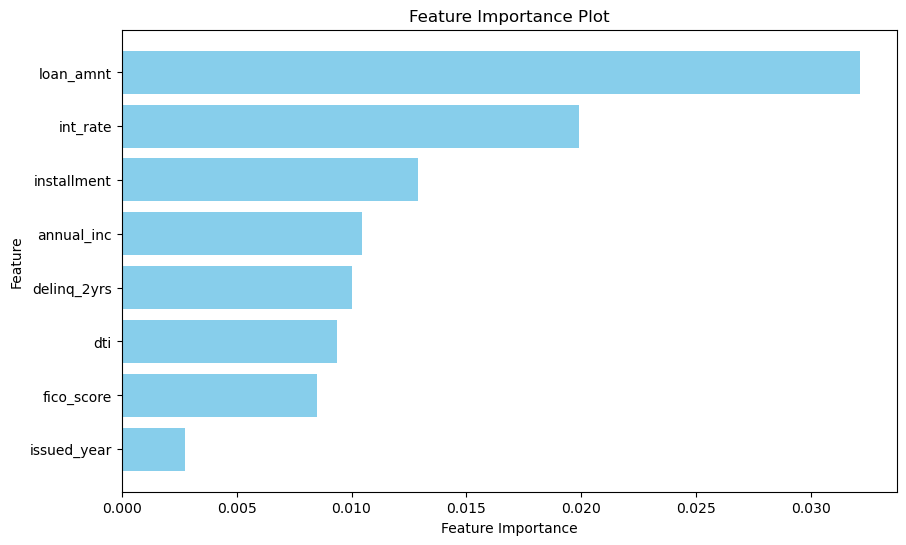

In [19]:
# Define the list of columns you want to include in the weighted average analysis
selected_columns = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'delinq_2yrs', 'dti', 'fico_score', 'issued_year']

# Extract feature importances for selected columns
selected_feature_importances = [feature_importances[idx] for idx in sorted_indices if idx < len(selected_columns)]

# Create a bar plot for feature importances
plt.figure(figsize=(10, 6))
plt.barh(selected_columns, selected_feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top

# Save the plot as a PNG file
plt.savefig('feature_importance_plot.png')

# Show the plot
plt.show()

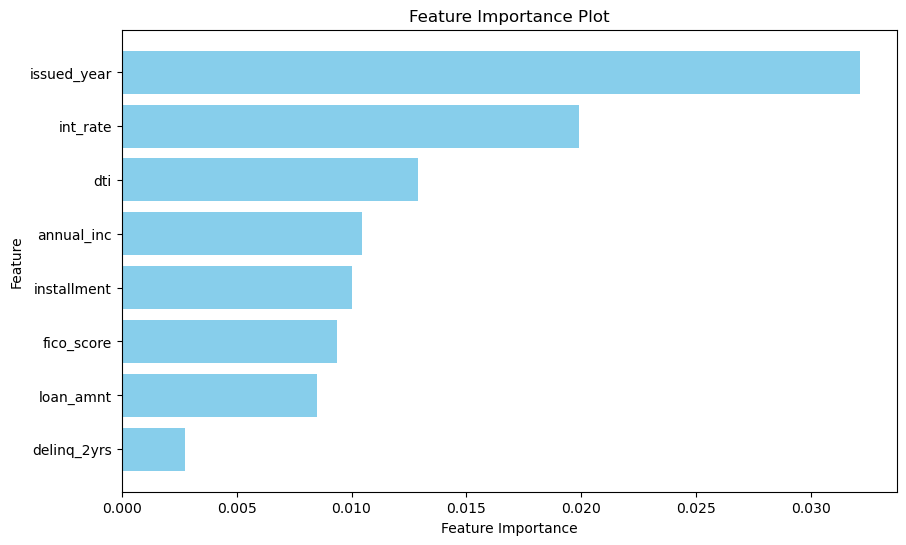

In [20]:
# Extract feature importances for selected columns
selected_feature_importances = [feature_importances[idx] for idx in sorted_indices if idx < len(selected_columns)]
selected_feature_names = [selected_columns[idx] for idx in sorted_indices if idx < len(selected_columns)]

# Create a bar plot for feature importances
plt.figure(figsize=(10, 6))
plt.barh(selected_feature_names, selected_feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top

# Save the plot as a PNG file
plt.savefig('feature_importance_plot.png')

# Show the plot
plt.show()